# 03 - Modélisation et prédiction (bureau de vote)

Objectif : tester des algorithmes robustes (baseline + gradient boosting) sur les données prétraitées, évaluer via validation temporelle, puis projeter les municipales 2026 bureau par bureau avant intégration Gradio.

## Plan
- Charger les données bloc-level (`data/processed/elections_blocs.parquet` ou CSV)
- Construire les features (lags, participation, croissance population, type de scrutin)
- Définir deux familles de modèles :
  - Baseline régression régularisée (référence interprétable)
  - Gradient Boosting (HistGradientBoosting par défaut ; LightGBM/XGBoost/CatBoost si installés)
- Validation temporelle (split par année) : MAE, RMSE, gagnant du bureau
- Entrainement final + projection municipales 2026 (tour 1)
- Sauvegarde des prédictions pour Gradio

## Retour rapide sur la demarche (points forts)

1. **Bonne separation preprocessing / modele**
   - `ColumnTransformer` avec pipelines numeriques et categoriels → propre
   - Imputation integree dans le pipeline → pas de data leakage
2. **Validation temporelle**
   - `TimeSeriesSplit` adapte au contexte temporel
   - Bonne discipline train/test dans le temps
3. **Comparaison de plusieurs modeles**
   - Baseline
   - Ridge / ElasticNet
   - Modeles plus complexes (LGBM)
4. **Gestion optionnelle des poids**
   - Logique `USE_WEIGHTED_MODEL` bien pensee
   - Impact metier de la target pris en compte

## Axes d'amelioration concrets pour gagner en score

### 1) Feature engineering (levier n°1)
Ajouter des features temporelles avant le pipeline et les inclure dans `NUM_FEATURES`:

- **Lags** : `part_bloc_lag_1`, `lag_7`, `lag_14`, `lag_28`
- **Stats glissantes** : `rolling_mean_7`, `rolling_std_14`, `rolling_max_30`
- **Calendrier** : jour/semaine/mois en sin/cos, jours feries si pertinent
- **Interactions** : produits et ratios (ex: volume / capacite)

### 2) Encodage categoriel plus performant
- Tester `OrdinalEncoder` avec LGBM
- Ou passer les features en `category` si possible
- Si forte cardinalite: target encoding (ex: `category_encoders`)

### 3) Optimisation des hyperparametres
- `RandomizedSearchCV` avec `TimeSeriesSplit`
- Priorite LGBM: `num_leaves`, `max_depth`, `learning_rate`, `min_child_samples`, `subsample`, `colsample_bytree`

### 4) Gestion de la target
- Tester `log1p(target)` puis inverse a la prediction
- Ou loss plus robuste (Huber, quantile)
- Verifier ou se situent les plus grosses erreurs

### 5) Selection / reduction de features
- Importance LGBM pour filtrer
- Suppression des features peu informatives
- PCA sur numeriques (a tester)

### 6) Analyse fine des erreurs
- Erreurs par periode et par segment
- Identifier les regimes ou ca degrade

## Priorites (impact)
1. Feature engineering temporel (lags + rolling)
2. Tuning LGBM
3. Encodage categoriel adapte
4. Analyse d'erreurs ciblee
5. Ajustement target / loss


In [ ]:
from pathlib import Path
import sys
import warnings
import numpy as np
import pandas as pd
from datetime import datetime

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMRegressor was fitted with feature names",
)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import HistGradientBoostingRegressor

try:
    from lightgbm import LGBMRegressor
except Exception:
    LGBMRegressor = None

try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import catboost
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.append(str(PROJECT_ROOT))

from src.pipeline import normalize_bloc
from src.constants import CANDIDATE_CATEGORIES


In [ ]:
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
processed_path = PROCESSED_DIR / "elections_blocs.parquet"
csv_fallback = PROCESSED_DIR / "elections_blocs.csv"
COMMUNE_PREFIX = "34301"
FIG_DIR = PROJECT_ROOT / "output" / "modelisation"
FIG_DIR.mkdir(parents=True, exist_ok=True)
SAVE_FIGS = True

def save_fig(name: str) -> None:
    # Save figures in a dedicated folder, per report requirement
    if not SAVE_FIGS:
        return
    path = FIG_DIR / f"{name}.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print(f"Saved: {path}")

def build_elections_blocs_fallback() -> pd.DataFrame:
    from src.features.build_features import load_elections_long as load_elections_long_clean
    from src.pipeline import (
        load_bloc_mapping,
        expand_voix_by_bloc,
        attach_national_results,
        compute_population_growth,
        add_lag_features,
    )

    elections_long_path = INTERIM_DIR / "elections_long.parquet"
    mapping_path = PROJECT_ROOT / "data" / "mapping_candidats_blocs.csv"
    if not elections_long_path.exists():
        raise FileNotFoundError("Aucun fichier elections_long.parquet trouve dans data/interim.")
    if not mapping_path.exists():
        raise FileNotFoundError("Aucun fichier mapping_candidats_blocs.csv trouve dans data/.")

    elections_long = load_elections_long_clean(elections_long_path)
    if COMMUNE_PREFIX:
        elections_long = elections_long[
            elections_long["code_bv"].astype(str).str.startswith(COMMUNE_PREFIX)
        ]
    blocs = expand_voix_by_bloc(elections_long, load_bloc_mapping(mapping_path))
    blocs = attach_national_results(blocs)
    blocs = compute_population_growth(blocs, base_year=2014)
    blocs = add_lag_features(blocs)
    return blocs

if processed_path.exists():
    elections_blocs = pd.read_parquet(processed_path)
elif csv_fallback.exists():
    elections_blocs = pd.read_csv(csv_fallback, sep=";")
else:
    elections_blocs = pd.DataFrame()

if elections_blocs.empty:
    print("elections_blocs vide -> reconstruction depuis elections_long.parquet")
    elections_blocs = build_elections_blocs_fallback()

# Normalisations de base
for col in ["date_scrutin"]:
    if col in elections_blocs.columns:
        elections_blocs[col] = pd.to_datetime(elections_blocs[col])
for col in ["voix_bloc", "exprimes", "inscrits", "votants", "part_bloc", "part_bloc_lag1", "taux_participation_bv_lag1", "croissance_inscrits_depuis_base"]:
    if col in elections_blocs.columns:
        elections_blocs[col] = pd.to_numeric(elections_blocs[col], errors="coerce")

elections_blocs["bloc"] = elections_blocs["bloc"].apply(normalize_bloc)

print(elections_blocs.shape)
elections_blocs.head()


(1650, 24)


,code_bv,nom_bv,date_scrutin,annee,type_scrutin,tour,bloc,voix_bloc,exprimes,inscrits,...,taux_participation_bv,ecart_bloc_vs_national,ecart_participation_vs_nat,code_commune,nom_commune,croissance_inscrits_depuis_base,part_bloc_lag1,ecart_bloc_vs_national_lag1,taux_participation_bv_lag1,annee_centre
0,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,NaN,NaN,NaN,0.0
1,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0
2,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0
3,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0
4,343010001,NaN,2014-03-23,2014,municipales,1,centre,0.0,641,962,...,0.672557,0.0,0.004375,34301,Sete,0.0,0.0,0.0,0.672557,0.0


## Cadre strict Sete - municipales - tour 1


In [ ]:
SETE_CODE_COMMUNE = "34301"
TARGET_SCRUTIN = "municipales"
TARGET_TOUR = 1

def filter_sete(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    if "code_commune" in d.columns:
        d = d[d["code_commune"].astype(str) == SETE_CODE_COMMUNE]
    elif "libelle_commune" in d.columns:
        d = d[d["libelle_commune"].astype(str).str.lower().str.contains("sete", regex=False)]
    elif "nom_commune" in d.columns:
        d = d[d["nom_commune"].astype(str).str.lower().str.contains("sete", regex=False)]
    elif "code_bv" in d.columns:
        d["code_commune_guess"] = d["code_bv"].astype(str).str[:5]
        d = d[d["code_commune_guess"] == SETE_CODE_COMMUNE]
    else:
        raise ValueError("Impossible d'isoler Sete: aucune colonne commune detectee.")
    return d

def filter_muni_t1(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    if "type_scrutin" in d.columns:
        d = d[d["type_scrutin"].astype(str).str.lower().eq(TARGET_SCRUTIN)]
    if "tour" in d.columns:
        tour_vals = pd.to_numeric(d["tour"], errors="coerce").fillna(TARGET_TOUR).astype(int)
        d = d[tour_vals == TARGET_TOUR]
    return d

def assert_scope(df: pd.DataFrame, label: str) -> None:
    if df.empty:
        print(f"[{label}] dataframe vide.")
        return
    if "code_commune" in df.columns:
        codes = df["code_commune"].astype(str).unique().tolist()
        if len(codes) > 1 or (codes and codes[0] != SETE_CODE_COMMUNE):
            print(f"[{label}] codes_commune inattendus: {sorted(set(codes))[:5]}")
    if "type_scrutin" in df.columns:
        types = sorted(df["type_scrutin"].astype(str).str.lower().unique().tolist())
        print(f"[{label}] types: {types}")
    if "tour" in df.columns:
        tours = sorted(df["tour"].astype(str).unique().tolist())
        print(f"[{label}] tours: {tours}")

base_df = filter_sete(elections_blocs)
sete_all = base_df.copy()
sete_muni_t1 = filter_muni_t1(sete_all)

rows_sete = len(sete_all)
rows_muni = len(sete_muni_t1)
bureaux_sete = sete_all["code_bv"].nunique() if "code_bv" in sete_all else None
bureaux_muni = sete_muni_t1["code_bv"].nunique() if "code_bv" in sete_muni_t1 else None
print(f"Rows Sete: {rows_sete} | bureaux: {bureaux_sete}")
print(f"Rows Sete muni T1: {rows_muni} | bureaux: {bureaux_muni}")
if "date_scrutin" in sete_muni_t1.columns:
    print(sete_muni_t1["date_scrutin"].dt.year.value_counts().sort_index())

assert_scope(sete_all, "sete_all")
assert_scope(sete_muni_t1, "sete_muni_t1")


Rows Sete: 1650 | bureaux: 33
Rows Sete muni T1: 302 | bureaux: 31
date_scrutin
2014    240
2020     62
Name: count, dtype: int64
[sete_all] types: ['departementales', 'europeennes', 'legislatives', 'municipales', 'presidentielles', 'regionales']
[sete_all] tours: ['1', '2']
[sete_muni_t1] types: ['municipales']
[sete_muni_t1] tours: ['1']


## Fonctions utilitaires : features, splits et métriques
- Construction d'une table modèle (une ligne = bureau x bloc x scrutin)
- Validation temporelle : split par années croissantes pour éviter la fuite d'info
- Calcul des métriques : MAE, RMSE, exactitude du gagnant du bureau (classement par bloc)

In [ ]:
TARGET_ELECTION = "municipales"
TARGET_YEAR = 2026
PREDICTION_DATE = pd.Timestamp(f"{TARGET_YEAR}-03-15")

LAG_STEPS = [1, 2, 3, 4, 7, 14, 28]
ROLL_WINDOWS = [3, 5, 7]

NUM_FEATURES_BASE = [
    "annee",
    "tour",
    "annee_centre",
    "is_2020",
    "taux_participation_bv",
    "ecart_bloc_vs_national",
    "croissance_inscrits_depuis_base",
    "month_sin",
    "month_cos",
    "dow_sin",
    "dow_cos",
    "voix_bloc_sur_inscrits",
    "exprimes_sur_inscrits",
    "votants_sur_inscrits",
    "part_bloc_trend_1",
    "part_bloc_trend_2",
    "part_bloc_lag1_x_participation",
    "part_bloc_lag1_x_ecart_nat",
    "participation_x_ecart_nat",
    "y_lag1_bv",
    "y_lag2_bv",
    "y_rollmean_3_bv",
    "y_trend_bv",
    "y_comm_lag1",
]

NUM_FEATURES = (
    NUM_FEATURES_BASE
    + [f"part_bloc_lag{lag}" for lag in LAG_STEPS]
    + [f"taux_participation_bv_lag{lag}" for lag in LAG_STEPS]
    + [f"ecart_bloc_vs_national_lag{lag}" for lag in LAG_STEPS]
    + [f"part_bloc_roll_mean_{w}" for w in ROLL_WINDOWS]
    + [f"part_bloc_roll_std_{w}" for w in ROLL_WINDOWS]
    + [f"part_bloc_roll_max_{w}" for w in ROLL_WINDOWS]
    + [f"taux_participation_roll_mean_{w}" for w in ROLL_WINDOWS]
)

CAT_FEATURES = ["bloc", "type_scrutin"]


def prepare_base_table(df: pd.DataFrame) -> pd.DataFrame:
    base = df.copy()
    if "code_bv" in base.columns:
        base["code_bv"] = base["code_bv"].astype(str)
    if "code_commune" in base.columns:
        base["code_commune"] = base["code_commune"].astype(str)
    base["bloc"] = base["bloc"].apply(normalize_bloc)
    base["type_scrutin"] = base["type_scrutin"].fillna("inconnu").astype(str).str.lower()
    base["tour"] = pd.to_numeric(base["tour"], errors="coerce").fillna(1).astype(int)
    if "date_scrutin" in base.columns:
        base["date_scrutin"] = pd.to_datetime(base["date_scrutin"], errors="coerce")
    if "annee" not in base.columns and "date_scrutin" in base.columns:
        base["annee"] = base["date_scrutin"].dt.year
    if "annee_centre" not in base.columns and "annee" in base.columns:
        base["annee_centre"] = base["annee"] - base["annee"].median()
    if "annee" in base.columns:
        base["is_2020"] = (base["annee"] == 2020).astype(int)
    # Ne conserver que les 1ers tours (sauf europeennes qui n'ont qu'un tour)
    if "tour" in base.columns and "type_scrutin" in base.columns:
        base = base[(base["tour"] == 1) | (base["type_scrutin"] == "europeennes")].copy()

    for col in [
        "voix_bloc",
        "exprimes",
        "inscrits",
        "votants",
        "part_bloc",
        "taux_participation_bv",
        "ecart_bloc_vs_national",
        "croissance_inscrits_depuis_base",
    ]:
        if col in base.columns:
            base[col] = pd.to_numeric(base[col], errors="coerce")

    # Cible : part_bloc, calculee si manquante
    if "part_bloc" not in base or base["part_bloc"].isna().all():
        if "voix_bloc" in base.columns and "exprimes" in base.columns:
            denom = base["exprimes"].replace({0: np.nan})
            base["part_bloc"] = base["voix_bloc"] / denom
    base["part_bloc"] = pd.to_numeric(base["part_bloc"], errors="coerce")
    return base


def add_calendar_features(base: pd.DataFrame) -> pd.DataFrame:
    if "date_scrutin" not in base.columns:
        return base
    dt = pd.to_datetime(base["date_scrutin"], errors="coerce")
    base["month"] = dt.dt.month
    base["month_sin"] = np.sin(2 * np.pi * base["month"] / 12)
    base["month_cos"] = np.cos(2 * np.pi * base["month"] / 12)
    base["dow"] = dt.dt.dayofweek
    base["dow_sin"] = np.sin(2 * np.pi * base["dow"] / 7)
    base["dow_cos"] = np.cos(2 * np.pi * base["dow"] / 7)
    return base


def add_lag_rolling_features(base: pd.DataFrame) -> pd.DataFrame:
    required = {"code_bv", "bloc", "date_scrutin"}
    if not required.issubset(base.columns):
        return base
    base = base.sort_values(["code_bv", "bloc", "date_scrutin"]).reset_index(drop=True)
    group = base.groupby(["code_bv", "bloc"], sort=False)

    for lag in LAG_STEPS:
        base[f"part_bloc_lag{lag}"] = group["part_bloc"].shift(lag)
        if "taux_participation_bv" in base.columns:
            base[f"taux_participation_bv_lag{lag}"] = group["taux_participation_bv"].shift(lag)
        if "ecart_bloc_vs_national" in base.columns:
            base[f"ecart_bloc_vs_national_lag{lag}"] = group["ecart_bloc_vs_national"].shift(lag)

    for window in ROLL_WINDOWS:
        base[f"part_bloc_roll_mean_{window}"] = (
            group["part_bloc"]
            .apply(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())
            .reset_index(level=[0, 1], drop=True)
        )
        base[f"part_bloc_roll_std_{window}"] = (
            group["part_bloc"]
            .apply(lambda s: s.shift(1).rolling(window=window, min_periods=1).std())
            .reset_index(level=[0, 1], drop=True)
        )
        base[f"part_bloc_roll_max_{window}"] = (
            group["part_bloc"]
            .apply(lambda s: s.shift(1).rolling(window=window, min_periods=1).max())
            .reset_index(level=[0, 1], drop=True)
        )
        if "taux_participation_bv" in base.columns:
            base[f"taux_participation_roll_mean_{window}"] = (
                group["taux_participation_bv"]
                .apply(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())
                .reset_index(level=[0, 1], drop=True)
            )
    return base


def add_bureau_bloc_features(base: pd.DataFrame, y_col: str = "part_bloc") -> pd.DataFrame:
    required = {"code_bv", "bloc", "date_scrutin"}
    if not required.issubset(base.columns):
        return base
    base = base.sort_values(["code_bv", "bloc", "date_scrutin"]).reset_index(drop=True)
    group = base.groupby(["code_bv", "bloc"], sort=False)

    base["y_lag1_bv"] = group[y_col].shift(1)
    base["y_lag2_bv"] = group[y_col].shift(2)

    shifted = group[y_col].shift(1)
    base["y_rollmean_3_bv"] = (
        shifted.groupby([base["code_bv"], base["bloc"]])
        .rolling(3, min_periods=1)
        .mean()
        .reset_index(level=[0, 1], drop=True)
    )

    if "y_lag1_bv" in base.columns and "y_lag2_bv" in base.columns:
        base["y_trend_bv"] = base["y_lag1_bv"] - base["y_lag2_bv"]
    return base


def add_commune_bloc_features(base: pd.DataFrame, y_col: str = "part_bloc") -> pd.DataFrame:
    d = base.copy()
    if "code_commune" not in d.columns and "code_bv" in d.columns:
        d["code_commune"] = d["code_bv"].astype(str).str[:5]
    required = {"code_commune", "bloc", "date_scrutin"}
    if not required.issubset(d.columns):
        return d

    def weighted_avg(g: pd.DataFrame) -> float:
        vals = g[y_col]
        if vals.dropna().empty:
            return float("nan")
        if "exprimes" in g.columns:
            weights = g["exprimes"].fillna(1).clip(lower=1)
            return float(np.average(vals, weights=weights))
        return float(vals.mean())

    rows = []
    for (code_commune, bloc, date_scrutin), g in (
        d.sort_values("date_scrutin")
        .groupby(["code_commune", "bloc", "date_scrutin"], sort=False)
    ):
        rows.append(
            {
                "code_commune": code_commune,
                "bloc": bloc,
                "date_scrutin": date_scrutin,
                "y_comm": weighted_avg(g),
            }
        )
    if not rows:
        return d
    agg = pd.DataFrame(rows)
    agg = agg.sort_values(["code_commune", "bloc", "date_scrutin"]).reset_index(drop=True)
    agg["y_comm_lag1"] = agg.groupby(["code_commune", "bloc"], sort=False)["y_comm"].shift(1)

    d = d.merge(
        agg[["code_commune", "bloc", "date_scrutin", "y_comm_lag1"]],
        on=["code_commune", "bloc", "date_scrutin"],
        how="left",
    )
    return d


def add_interaction_features(base: pd.DataFrame) -> pd.DataFrame:
    if {"voix_bloc", "inscrits"}.issubset(base.columns):
        denom = base["inscrits"].replace({0: np.nan})
        base["voix_bloc_sur_inscrits"] = base["voix_bloc"] / denom
    if {"exprimes", "inscrits"}.issubset(base.columns):
        denom = base["inscrits"].replace({0: np.nan})
        base["exprimes_sur_inscrits"] = base["exprimes"] / denom
    if {"votants", "inscrits"}.issubset(base.columns):
        denom = base["inscrits"].replace({0: np.nan})
        base["votants_sur_inscrits"] = base["votants"] / denom

    if {"part_bloc_lag1", "taux_participation_bv"}.issubset(base.columns):
        base["part_bloc_lag1_x_participation"] = base["part_bloc_lag1"] * base["taux_participation_bv"]
    if {"part_bloc_lag1", "ecart_bloc_vs_national"}.issubset(base.columns):
        base["part_bloc_lag1_x_ecart_nat"] = base["part_bloc_lag1"] * base["ecart_bloc_vs_national"]
    if {"taux_participation_bv", "ecart_bloc_vs_national"}.issubset(base.columns):
        base["participation_x_ecart_nat"] = base["taux_participation_bv"] * base["ecart_bloc_vs_national"]

    if {"part_bloc_lag1", "part_bloc_lag2"}.issubset(base.columns):
        base["part_bloc_trend_1"] = base["part_bloc_lag1"] - base["part_bloc_lag2"]
    if {"part_bloc_lag1", "part_bloc_lag4"}.issubset(base.columns):
        base["part_bloc_trend_2"] = base["part_bloc_lag1"] - base["part_bloc_lag4"]
    return base


def build_model_table(df: pd.DataFrame, drop_na_target: bool = True) -> pd.DataFrame:
    base = prepare_base_table(df)
    base = add_calendar_features(base)
    base = add_lag_rolling_features(base)
    base = add_bureau_bloc_features(base)
    base = add_commune_bloc_features(base)
    base = add_interaction_features(base)
    if drop_na_target:
        base = base.dropna(subset=["part_bloc"])
    return base


def time_series_folds(df: pd.DataFrame, n_splits: int = 4):
    # Split sur la base de l'annee, en conservant l'ordre chronologique
    df_sorted = df.sort_values("annee").reset_index(drop=True)
    n_samples = len(df_sorted)
    if n_samples < 2:
        return []
    max_splits = min(n_splits, n_samples - 1)
    if max_splits < n_splits:
        print(f"n_splits reduit a {max_splits} (n_samples={n_samples}).")
    tscv = TimeSeriesSplit(n_splits=max_splits)
    for train_idx, test_idx in tscv.split(df_sorted):
        yield train_idx, test_idx


def time_series_event_folds(df: pd.DataFrame, n_splits: int = 4):
    """
    Split par scrutin (type/date/tour) pour eviter toute fuite.
    Chaque fold teste des scrutins entiers, dans l'ordre chronologique.
    """
    required = {"date_scrutin", "type_scrutin", "tour"}
    if not required.issubset(df.columns):
        raise ValueError(f"Colonnes manquantes pour le split strict: {required - set(df.columns)}")
    dates = pd.to_datetime(df["date_scrutin"], errors="coerce")
    event_key = (
        df["type_scrutin"].astype(str).str.lower().str.strip()
        + "|" + df["tour"].astype(str)
        + "|" + dates.dt.strftime("%Y-%m-%d").fillna("")
    )
    events = (
        pd.DataFrame({
            "type_scrutin": df["type_scrutin"].astype(str).str.lower().str.strip(),
            "tour": df["tour"].astype(str),
            "date_scrutin": dates,
            "event_key": event_key,
        })
        .dropna(subset=["date_scrutin"])
        .drop_duplicates(subset=["event_key"])
        .sort_values(["date_scrutin", "type_scrutin", "tour"])
        .reset_index(drop=True)
    )
    if events.empty:
        return []
    n_events = len(events)
    max_splits = min(n_splits, n_events - 1)
    if max_splits < 1:
        return []
    if max_splits < n_splits:
        print(f"n_splits reduit a {max_splits} (n_events={n_events}).")
    tscv = TimeSeriesSplit(n_splits=max_splits)
    for train_evt_idx, test_evt_idx in tscv.split(events):
        train_keys = set(events.iloc[train_evt_idx]["event_key"])
        test_keys = set(events.iloc[test_evt_idx]["event_key"])
        train_idx = df.index[event_key.isin(train_keys)].to_numpy()
        test_idx = df.index[event_key.isin(test_keys)].to_numpy()
        yield train_idx, test_idx


def make_event_folds(df: pd.DataFrame, n_splits: int = 4, gap_events: int = 0):
    if "date_scrutin" not in df.columns:
        return []
    d = df.sort_values("date_scrutin").reset_index(drop=False)
    type_vals = d["type_scrutin"].astype(str) if "type_scrutin" in d.columns else pd.Series("", index=d.index)
    tour_vals = d["tour"].astype(str) if "tour" in d.columns else pd.Series("", index=d.index)
    d["_event"] = (
        d["date_scrutin"].astype(str)
        + "|" + type_vals
        + "|" + tour_vals
    )
    events = d["_event"].drop_duplicates().tolist()
    n = len(events)
    if n < 2:
        return []
    folds = []
    for k in range(1, n_splits + 1):
        cut = int(n * (0.5 + 0.1 * k))
        cut = min(cut, n - 1)
        train_events = events[:max(0, cut - gap_events)]
        test_events = events[cut:cut + 1]
        tr = d.loc[d["_event"].isin(train_events), "index"].to_numpy()
        te = d.loc[d["_event"].isin(test_events), "index"].to_numpy()
        if len(tr) and len(te):
            folds.append((tr, te))
    return folds


In [ ]:
import inspect
from sklearn.base import clone

def supports_sample_weight(estimator) -> bool:
    try:
        return "sample_weight" in inspect.signature(estimator.fit).parameters
    except Exception:
        return False

class HurdleModel(BaseEstimator, RegressorMixin):
    def __init__(self, clf, reg):
        self.clf = clf
        self.reg = reg

    def fit(self, X, y, sample_weight=None):
        y = np.asarray(y)
        y_bin = (y > 0).astype(int)

        self.clf_ = clone(self.clf)
        self.reg_ = clone(self.reg)

        if supports_sample_weight(self.clf_):
            self.clf_.fit(X, y_bin, sample_weight=sample_weight)
        else:
            self.clf_.fit(X, y_bin)

        mask = y > 0
        if mask.any():
            sw2 = None if sample_weight is None else np.asarray(sample_weight)[mask]
            if supports_sample_weight(self.reg_):
                self.reg_.fit(X[mask], y[mask], sample_weight=sw2)
            else:
                self.reg_.fit(X[mask], y[mask])
        else:
            self.reg_ = None
        return self

    def predict(self, X):
        if hasattr(self.clf_, "predict_proba"):
            p_nz = self.clf_.predict_proba(X)[:, 1]
        elif hasattr(self.clf_, "decision_function"):
            scores = self.clf_.decision_function(X)
            p_nz = 1 / (1 + np.exp(-scores))
        else:
            p_nz = self.clf_.predict(X)
        if self.reg_ is None:
            y_hat = np.zeros(len(X))
        else:
            y_hat = self.reg_.predict(X)
        return np.clip(p_nz * y_hat, 0, 1)


## Préparation du jeu d'entraînement
- Sélection des colonnes utiles
- Imputation des valeurs manquantes (médiane pour numériques)
- Encodage one-hot pour les variables catégorielles

In [ ]:
model_df = build_model_table(base_df, drop_na_target=True)
# Assurer un ordre chronologique coherent avec les folds
model_df = model_df.sort_values("annee").reset_index(drop=True)

feature_cols = NUM_FEATURES + CAT_FEATURES

missing_cols = [c for c in feature_cols if c not in model_df.columns]
if missing_cols:
    print(f"Features absentes et ignorees: {missing_cols}")
    feature_cols = [c for c in feature_cols if c in model_df.columns]

# Supprimer les features entierement vides (ex: ecarts nationaux si non disponibles)
all_na_cols = [c for c in feature_cols if model_df[c].isna().all()]
if all_na_cols:
    print(f"Features supprimees car entierement NA: {all_na_cols}")
    feature_cols = [c for c in feature_cols if c not in all_na_cols]

X = model_df[feature_cols].reset_index(drop=True)
y = model_df["part_bloc"].reset_index(drop=True)
# Folds temporels alignes sur le DataFrame reindexe
folds = list(time_series_event_folds(model_df.reset_index(drop=True), n_splits=4))


In [ ]:
# Pondération des observations (optionnel)
def build_sample_weights(df: pd.DataFrame, mode: str = 'bloc_value', alpha: float = 2.0) -> pd.Series:
    weights = pd.Series(1.0, index=df.index, dtype='float')
    if mode in ('bloc', 'bloc_value'):
        bloc_counts = df['bloc'].value_counts()
        if not bloc_counts.empty:
            inv = bloc_counts.max() / bloc_counts
            weights *= df['bloc'].map(inv).fillna(1.0)
    if mode in ('value', 'bloc_value'):
        y = df['part_bloc'].clip(lower=0)
        weights *= 1 + alpha * y
    return weights

sample_weights = build_sample_weights(model_df, mode='bloc_value', alpha=2.0)


## Définition des modèles à tester
- **Ridge** sur la cible directe (baseline interprétable)
- **HistGradientBoostingRegressor** (robuste sur tabulaire)
- **LightGBM/XGBoost/CatBoost** si disponibles (recommandés en production)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_features = [c for c in NUM_FEATURES if c in feature_cols]
categorical_features = [c for c in CAT_FEATURES if c in feature_cols]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("variance", VarianceThreshold(threshold=1e-6)),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

numeric_transformer_lgbm = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("variance", VarianceThreshold(threshold=1e-6)),
    ]
)

categorical_transformer_lgbm = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

preprocessor_lgbm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lgbm, numeric_features),
        ("cat", categorical_transformer_lgbm, categorical_features),
    ]
)


In [ ]:
models = []

ridge_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", Ridge(alpha=1.0)),
    ]
)
models.append(("ridge", ridge_model))

ridge_reg = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("model", Ridge(alpha=10.0)),
    ]
)
models.append(("ridge_reg", ridge_reg))

# HistGradientBoosting (natif sklearn)
gbr_model = Pipeline(
    steps=[
        ("prep", preprocessor),
        (
            "model",
            HistGradientBoostingRegressor(
                max_depth=6,
                learning_rate=0.05,
                max_iter=500,
                min_samples_leaf=20,
                l2_regularization=0.1,
            ),
        ),
    ]
)
models.append(("hist_gbr", gbr_model))

gbr_reg = Pipeline(
    steps=[
        ("prep", preprocessor),
        (
            "model",
            HistGradientBoostingRegressor(
                max_depth=4,
                learning_rate=0.05,
                max_iter=400,
                min_samples_leaf=50,
                l2_regularization=1.0,
            ),
        ),
    ]
)
models.append(("hist_gbr_reg", gbr_reg))

gbr_robust = Pipeline(
    steps=[
        ("prep", preprocessor),
        (
            "model",
            HistGradientBoostingRegressor(
                loss="absolute_error",
                max_depth=5,
                learning_rate=0.05,
                max_iter=400,
                min_samples_leaf=30,
                l2_regularization=0.2,
            ),
        ),
    ]
)
models.append(("hist_gbr_robust", gbr_robust))

# LightGBM si dispo (souvent le meilleur sur ce type de donnees)
if LGBMRegressor is not None:
    lgbm = Pipeline(
        steps=[
            ("prep", preprocessor_lgbm),
            (
                "model",
                LGBMRegressor(
                    objective="regression",
                    n_estimators=800,
                    learning_rate=0.05,
                    max_depth=-1,
                    num_leaves=31,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    force_row_wise=True,
                    verbosity=-1,
                    random_state=42,
                ),
            ),
        ]
    )
    models.append(("lightgbm", lgbm))

    lgbm_reg = Pipeline(
        steps=[
            ("prep", preprocessor_lgbm),
            (
                "model",
                LGBMRegressor(
                    objective="regression",
                    n_estimators=600,
                    learning_rate=0.05,
                    max_depth=6,
                    num_leaves=16,
                    min_child_samples=20,
                    reg_alpha=0.0,
                    reg_lambda=0.5,
                    subsample=0.7,
                    colsample_bytree=0.7,
                    force_row_wise=True,
                    verbosity=-1,
                    random_state=42,
                ),
            ),
        ]
    )
    models.append(("lightgbm_reg", lgbm_reg))

    lgbm_log = TransformedTargetRegressor(
        regressor=Pipeline(
            steps=[
                ("prep", preprocessor_lgbm),
                (
                    "model",
                    LGBMRegressor(
                        objective="regression",
                        n_estimators=600,
                        learning_rate=0.05,
                        max_depth=-1,
                        num_leaves=31,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        force_row_wise=True,
                        verbosity=-1,
                        random_state=42,
                    ),
                ),
            ]
        ),
        func=np.log1p,
        inverse_func=np.expm1,
    )
    models.append(("lightgbm_log1p", lgbm_log))

    hurdle_clf = Pipeline(
        steps=[
            ("prep", preprocessor),
            ("model", LogisticRegression(max_iter=300)),
        ]
    )
    hurdle_reg = Pipeline(
        steps=[
            ("prep", preprocessor_lgbm),
            (
                "model",
                LGBMRegressor(
                    objective="regression",
                    n_estimators=600,
                    learning_rate=0.05,
                    max_depth=-1,
                    num_leaves=31,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    force_row_wise=True,
                    verbosity=-1,
                    random_state=42,
                ),
            ),
        ]
    )
    models.append(("hurdle_lgbm", HurdleModel(clf=hurdle_clf, reg=hurdle_reg)))

else:
    hurdle_clf = Pipeline(
        steps=[
            ("prep", preprocessor),
            ("model", LogisticRegression(max_iter=300)),
        ]
    )
    hurdle_reg = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                HistGradientBoostingRegressor(
                    max_depth=5,
                    learning_rate=0.05,
                    max_iter=300,
                    min_samples_leaf=30,
                    l2_regularization=0.2,
                ),
            ),
        ]
    )
    models.append(("hurdle_hist", HurdleModel(clf=hurdle_clf, reg=hurdle_reg)))

# XGBoost si dispo
if xgb is not None:
    xgb_model = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                xgb.XGBRegressor(
                    objective="reg:squarederror",
                    n_estimators=800,
                    learning_rate=0.05,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                ),
            ),
        ]
    )
    models.append(("xgboost", xgb_model))

    xgb_reg = Pipeline(
        steps=[
            ("prep", preprocessor),
            (
                "model",
                xgb.XGBRegressor(
                    objective="reg:squarederror",
                    n_estimators=600,
                    learning_rate=0.05,
                    max_depth=4,
                    min_child_weight=5,
                    reg_alpha=0.1,
                    reg_lambda=1.0,
                    subsample=0.7,
                    colsample_bytree=0.7,
                ),
            ),
        ]
    )
    models.append(("xgboost_reg", xgb_reg))

# CatBoost si dispo (gere bien les categoriels)


## Évaluation temporelle
Validation par TimeSeriesSplit (train sur années passées, test sur années futures). Mesures :
- MAE / RMSE sur part des voix
- Exactitude du gagnant du bureau (classement par bloc sur chaque scrutin)

In [ ]:
def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    evs = explained_variance_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    denom = float(np.sum(np.abs(y_true)))
    wape = float(np.sum(np.abs(y_true - y_pred)) / denom) if denom > 0 else np.nan
    smape = float(np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)))
    bias = float(np.mean(y_pred - y_true))
    return {
        "mae": float(mae),
        "rmse": float(rmse),
        "medae": float(medae),
        "r2": float(r2),
        "explained_var": float(evs),
        "wape": float(wape),
        "smape": float(smape),
        "bias": float(bias),
    }


def weighted_mae(y_true, y_pred, weights):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    weights = np.asarray(weights)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if not mask.any():
        return np.nan
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    weights = weights[mask]
    denom = float(np.sum(weights))
    if denom <= 0:
        return np.nan
    return float(np.sum(np.abs(y_true - y_pred) * weights) / denom)


def normalize_predictions_by_bureau(df: pd.DataFrame, pred_col: str, out_col: str = "p_norm") -> pd.DataFrame:
    out = df.copy()
    out[pred_col] = out[pred_col].clip(0, 1)
    out[out_col] = out.groupby("code_bv")[pred_col].transform(lambda s: s / max(s.sum(), 1e-9))
    return out


def winner_accuracy_from_df(df: pd.DataFrame, pred_col: str, true_col: str = "y_true") -> float:
    if df.empty:
        return np.nan
    winners_true = (
        df.loc[df.groupby("code_bv")[true_col].idxmax(), ["code_bv", "bloc"]]
        .set_index("code_bv")["bloc"]
    )
    winners_pred = (
        df.loc[df.groupby("code_bv")[pred_col].idxmax(), ["code_bv", "bloc"]]
        .set_index("code_bv")["bloc"]
    )
    common = winners_true.index.intersection(winners_pred.index)
    if common.empty:
        return np.nan
    return float((winners_true.loc[common] == winners_pred.loc[common]).mean())


def fit_with_optional_weights(model, X_train, y_train, sample_weight=None):
    if sample_weight is None:
        model.fit(X_train, y_train)
        return

    if isinstance(model, TransformedTargetRegressor):
        reg = model.regressor
        if hasattr(reg, "named_steps") and "model" in reg.named_steps:
            if supports_sample_weight(reg.named_steps["model"]):
                model.fit(X_train, y_train, model__sample_weight=sample_weight)
                return
        elif supports_sample_weight(reg):
            model.fit(X_train, y_train, sample_weight=sample_weight)
            return
        model.fit(X_train, y_train)
        return

    if hasattr(model, "named_steps"):
        estimator = model.named_steps.get("model")
        if supports_sample_weight(estimator):
            model.fit(X_train, y_train, model__sample_weight=sample_weight)
        else:
            model.fit(X_train, y_train)
        return

    if supports_sample_weight(model):
        model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)


def evaluate_model(name, model, X, y, folds, sample_weights=None, compute_winner_acc=True, df_for_winner=None):
    metric_store = {
        "mae": [],
        "rmse": [],
        "medae": [],
        "r2": [],
        "explained_var": [],
        "wape": [],
        "smape": [],
        "bias": [],
    }
    win_accs = []
    folds_used = 0
    if not folds:
        print("Aucun fold disponible pour l'evaluation.")
        return {"model": name, **{k: np.nan for k in metric_store}, "winner_acc": np.nan, "folds_used": 0}
    weights = None if sample_weights is None else np.asarray(sample_weights)
    for train_idx, test_idx in folds:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        w_train = None if weights is None else weights[train_idx]
        # CatBoost peut planter si la cible est constante sur le fold ; on ajoute un tres leger bruit
        if y_train.nunique() <= 1:
            y_train = y_train + np.random.normal(0, 1e-6, size=len(y_train))
        try:
            fit_with_optional_weights(model, X_train, y_train, sample_weight=w_train)
            preds = model.predict(X_test)
        except Exception as exc:
            print(f"Skip fold for {name} (reason: {exc})")
            continue
        fold_metrics = regression_metrics(y_test, preds)
        for key, value in fold_metrics.items():
            metric_store[key].append(value)
        if compute_winner_acc:
            ref_df = df_for_winner if df_for_winner is not None else model_df
            win_accs.append(
                winner_accuracy(
                    y_test.values,
                    preds,
                    blocs=ref_df.iloc[test_idx]["bloc"],
                    bv_codes=ref_df.iloc[test_idx]["code_bv"],
                )
            )
        folds_used += 1
    summary = {
        "model": name,
        **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},
        "winner_acc": np.nan if (not compute_winner_acc) or all(np.isnan(win_accs)) or len(win_accs) == 0 else float(np.nanmean(win_accs)),
        "folds_used": folds_used,
    }
    return summary

results = []
for name, model in models:
    print(f"Evaluation {name}...")
    res = evaluate_model(name, model, X, y, folds)
    results.append(res)

results_df = pd.DataFrame(results).sort_values("mae")

# Hyperparameter tuning (priorite LightGBM)
RUN_TUNING = True
tuned_models = []
tuned_results = []

if RUN_TUNING and folds:
    model_lookup = dict(models)
    if LGBMRegressor is not None and "lightgbm" in model_lookup:
        print("RandomizedSearchCV lightgbm...")
        lgbm_base = model_lookup["lightgbm"]
        param_dist = {
            "model__num_leaves": [16, 31, 63, 127],
            "model__max_depth": [-1, 4, 6, 8, 10],
            "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
            "model__n_estimators": [400, 600, 800, 1000],
            "model__min_child_samples": [10, 20, 40, 80],
            "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
            "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
            "model__reg_alpha": [0.0, 0.1, 0.5],
            "model__reg_lambda": [0.0, 0.5, 1.0],
        }
        search = RandomizedSearchCV(
            lgbm_base,
            param_distributions=param_dist,
            n_iter=25,
            scoring="neg_mean_absolute_error",
            cv=folds,
            random_state=42,
            n_jobs=1,
        )
        fit_params = {}
        if "sample_weights" in globals():
            fit_params = {"model__sample_weight": sample_weights}
        search.fit(X, y, **fit_params)
        tuned_model = search.best_estimator_
        tuned_models.append(("lightgbm_tuned", tuned_model))
    elif "hist_gbr" in model_lookup:
        print("RandomizedSearchCV hist_gbr...")
        hgb_base = model_lookup["hist_gbr"]
        param_dist = {
            "model__max_depth": [3, 4, 5, 6],
            "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
            "model__max_iter": [200, 400, 600, 800],
            "model__min_samples_leaf": [10, 20, 40, 80],
            "model__l2_regularization": [0.0, 0.1, 0.5, 1.0],
        }
        search = RandomizedSearchCV(
            hgb_base,
            param_distributions=param_dist,
            n_iter=25,
            scoring="neg_mean_absolute_error",
            cv=folds,
            random_state=42,
            n_jobs=1,
        )
        search.fit(X, y)
        tuned_model = search.best_estimator_
        tuned_models.append(("hist_gbr_tuned", tuned_model))
    else:
        print("Aucun modele disponible pour le tuning.")

if tuned_models:
    existing_names = {name for name, _ in models}
    for name, model in tuned_models:
        if name not in existing_names:
            models.append((name, model))
    for name, model in tuned_models:
        tuned_results.append(evaluate_model(name, model, X, y, folds))
    tuned_results_df = pd.DataFrame(tuned_results)
    results_df = pd.concat([results_df, tuned_results_df], ignore_index=True).sort_values("mae")
else:
    tuned_results_df = pd.DataFrame()

results_df

# Comparaison ponderee
RUN_WEIGHTED = True
results_weighted_df = pd.DataFrame()
if RUN_WEIGHTED and "sample_weights" in globals():
    results_weighted = []
    for name, model in models:
        print(f"Evaluation ponderee {name}...")
        res = evaluate_model(name, model, X, y, folds, sample_weights=sample_weights)
        res["model"] = f"{name}__weighted"
        results_weighted.append(res)
    results_weighted_df = pd.DataFrame(results_weighted).sort_values("mae")
    results_weighted_df


Evaluation ridge...
Evaluation ridge_reg...
Evaluation hist_gbr...
Evaluation hist_gbr_reg...
Evaluation hist_gbr_robust...
Evaluation lightgbm...
Evaluation lightgbm_reg...
Evaluation lightgbm_log1p...
Evaluation hurdle_lgbm...


/Users/steph/Code/Python/Jupyter/Elections_Sete/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:641: UserWarning: Skipping features without any observed values: ['part_bloc_trend_1' 'part_bloc_trend_2' 'part_bloc_lag1_x_participation'
 'part_bloc_lag1_x_ecart_nat' 'y_lag1_bv' 'y_lag2_bv' 'y_rollmean_3_bv'
 'y_trend_bv' 'y_comm_lag1' 'part_bloc_lag1' 'part_bloc_lag2'
 'part_bloc_lag3' 'part_bloc_lag4' 'part_bloc_lag7' 'part_bloc_lag14'
 'part_bloc_lag28' 'taux_participation_bv_lag1'
 'taux_participation_bv_lag2' 'taux_participation_bv_lag3'
 'taux_participation_bv_lag4' 'taux_participation_bv_lag7'
 'taux_participation_bv_lag14' 'taux_participation_bv_lag28'
 'ecart_bloc_vs_national_lag1' 'ecart_bloc_vs_national_lag2'
 'ecart_bloc_vs_national_lag3' 'ecart_bloc_vs_national_lag4'
 'ecart_bloc_vs_national_lag7' 'ecart_bloc_vs_national_lag14'
 'ecart_bloc_vs_national_lag28' 'part_bloc_roll_mean_3'
 'part_bloc_roll_mean_5' 'part_bloc_roll_mean_7' 'part_bloc_roll_std_3'
 'part_bloc

Evaluation xgboost...
Evaluation xgboost_reg...
RandomizedSearchCV lightgbm...
Evaluation ponderee ridge...
Evaluation ponderee ridge_reg...
Evaluation ponderee hist_gbr...
Evaluation ponderee hist_gbr_reg...
Evaluation ponderee hist_gbr_robust...
Evaluation ponderee lightgbm...
Evaluation ponderee lightgbm_reg...
Evaluation ponderee lightgbm_log1p...
Evaluation ponderee hurdle_lgbm...


/Users/steph/Code/Python/Jupyter/Elections_Sete/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:641: UserWarning: Skipping features without any observed values: ['part_bloc_trend_1' 'part_bloc_trend_2' 'part_bloc_lag1_x_participation'
 'part_bloc_lag1_x_ecart_nat' 'y_lag1_bv' 'y_lag2_bv' 'y_rollmean_3_bv'
 'y_trend_bv' 'y_comm_lag1' 'part_bloc_lag1' 'part_bloc_lag2'
 'part_bloc_lag3' 'part_bloc_lag4' 'part_bloc_lag7' 'part_bloc_lag14'
 'part_bloc_lag28' 'taux_participation_bv_lag1'
 'taux_participation_bv_lag2' 'taux_participation_bv_lag3'
 'taux_participation_bv_lag4' 'taux_participation_bv_lag7'
 'taux_participation_bv_lag14' 'taux_participation_bv_lag28'
 'ecart_bloc_vs_national_lag1' 'ecart_bloc_vs_national_lag2'
 'ecart_bloc_vs_national_lag3' 'ecart_bloc_vs_national_lag4'
 'ecart_bloc_vs_national_lag7' 'ecart_bloc_vs_national_lag14'
 'ecart_bloc_vs_national_lag28' 'part_bloc_roll_mean_3'
 'part_bloc_roll_mean_5' 'part_bloc_roll_mean_7' 'part_bloc_roll_std_3'
 'part_bloc

Evaluation ponderee xgboost...
Evaluation ponderee xgboost_reg...
Evaluation ponderee lightgbm_tuned...


## Baseline naïf (dernier scrutin connu)
Utilise directement `part_bloc_lag1` comme prédicteur pour estimer si les modèles apportent un gain tangible par rapport au simple report du scrutin précédent.


In [ ]:
def evaluate_naive_last_observation(df: pd.DataFrame, folds):
    metric_store = {
        "mae": [],
        "rmse": [],
        "medae": [],
        "r2": [],
        "explained_var": [],
        "wape": [],
        "smape": [],
        "bias": [],
    }
    win_accs = []
    folds_used = 0
    if not folds:
        return {"model": "naive_last_election", **{k: np.nan for k in metric_store}, "winner_acc": np.nan, "folds_used": 0}
    for train_idx, test_idx in folds:
        test_df = df.iloc[test_idx]
        preds = test_df["part_bloc_lag1"]
        mask = preds.notna() & test_df["part_bloc"].notna()
        if not mask.any():
            continue
        y_true = test_df.loc[mask, "part_bloc"]
        y_pred = preds.loc[mask]
        fold_metrics = regression_metrics(y_true, y_pred)
        for key, value in fold_metrics.items():
            metric_store[key].append(value)
        win_accs.append(
            winner_accuracy(
                y_true.values,
                y_pred.values,
                blocs=test_df.loc[mask, "bloc"],
                bv_codes=test_df.loc[mask, "code_bv"],
            )
        )
        folds_used += 1
    return {
        "model": "naive_last_election",
        **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},
        "winner_acc": np.nan if all(np.isnan(win_accs)) or len(win_accs) == 0 else float(np.nanmean(win_accs)),
        "folds_used": folds_used,
    }

baseline_res = evaluate_naive_last_observation(model_df, folds)
results_df = pd.concat([pd.DataFrame([baseline_res]), results_df]).sort_values("mae").reset_index(drop=True)

USE_WEIGHTED_MODEL = False
if USE_WEIGHTED_MODEL and not results_weighted_df.empty:
    model_names = [name for name, _ in models]
    weighted_filtered = results_weighted_df[results_weighted_df["model"].str.contains("__weighted")].reset_index(drop=True)
    weighted_filtered["base_model"] = weighted_filtered["model"].str.replace("__weighted", "", regex=False)
    best_model_name = weighted_filtered.iloc[0]["base_model"]
    best_model = dict(models)[best_model_name]
else:
    model_names = [name for name, _ in models]
    model_results_df = results_df[results_df["model"].isin(model_names)].reset_index(drop=True)
    if model_results_df.empty:
        raise ValueError("Aucun modele candidat pour la selection finale.")
    best_model_name = model_results_df.iloc[0]["model"]
    best_model = dict(models)[best_model_name]
results_df


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/1556042094.py:38: RuntimeWarning: Mean of empty slice
  **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},


,model,mae,rmse,medae,r2,explained_var,wape,smape,bias,winner_acc,folds_used
0,naive_last_election,0.000000,0.000000,0.000000,1.000000,1.000000e+00,NaN,0.000000,0.000000,1.000000,4
1,hist_gbr_robust,0.009643,0.012091,0.011492,0.312966,7.499999e-01,1.000005,0.498431,-0.009643,0.887097,4
2,hurdle_lgbm,0.009670,0.012120,0.011516,-0.437024,-9.839159e-07,0.999999,1.999455,-0.009616,0.790323,4
3,ridge,0.009778,0.012245,0.011613,-0.437024,4.908845e-06,0.999998,1.999389,-0.009622,1.000000,4
4,ridge_reg,0.010161,0.012676,0.011996,-0.437045,-1.998693e-06,1.000015,1.999583,-0.009512,0.758065,4
5,lightgbm_tuned,0.018504,0.020952,0.020324,-0.437032,8.326673e-17,1.000001,1.996790,-0.000783,0.750000,4
6,hist_gbr_reg,0.020376,0.022910,0.022631,-0.437033,1.667306e-06,1.000005,1.998004,0.000996,0.951613,4
7,hist_gbr,0.023176,0.025663,0.024916,-0.437031,-4.710804e-07,1.000004,1.998956,0.003844,0.854839,4
8,xgboost_reg,0.023560,0.027128,0.025397,-0.437031,0.000000e+00,1.000000,1.878714,0.004273,0.750000,4
9,lightgbm_reg,0.023670,0.026830,0.025555,-0.437023,2.619311e-06,0.999997,1.998831,0.004315,0.943548,4


In [ ]:
from sklearn.base import clone

RUN_PER_BLOC = True
if not RUN_PER_BLOC:
    print("Evaluation par bloc desactivee.")
else:
    per_bloc_feature_cols = [c for c in feature_cols if c != "bloc"]
    per_bloc_num_features = [c for c in NUM_FEATURES if c in per_bloc_feature_cols]
    per_bloc_cat_features = [c for c in CAT_FEATURES if c != "bloc"]

    per_bloc_numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("variance", VarianceThreshold(threshold=1e-6)),
            ("scaler", StandardScaler()),
        ]
    )
    per_bloc_categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    per_bloc_preprocessor = ColumnTransformer(
        transformers=[
            ("num", per_bloc_numeric_transformer, per_bloc_num_features),
            ("cat", per_bloc_categorical_transformer, per_bloc_cat_features),
        ]
    )

    def rebuild_pipeline_with_preprocessor(pipeline_obj):
        if hasattr(pipeline_obj, "named_steps") and "model" in pipeline_obj.named_steps:
            estimator = pipeline_obj.named_steps["model"]
            return Pipeline([("prep", per_bloc_preprocessor), ("model", clone(estimator))])
        return clone(pipeline_obj)

    def make_per_bloc_model(base_model):
        if isinstance(base_model, HurdleModel):
            clf = rebuild_pipeline_with_preprocessor(base_model.clf)
            reg = rebuild_pipeline_with_preprocessor(base_model.reg)
            return HurdleModel(clf=clf, reg=reg)

        if isinstance(base_model, TransformedTargetRegressor):
            reg = base_model.regressor
            if hasattr(reg, "named_steps") and "model" in reg.named_steps:
                estimator = reg.named_steps["model"]
                reg_clone = Pipeline([("prep", per_bloc_preprocessor), ("model", clone(estimator))])
                return TransformedTargetRegressor(
                    regressor=reg_clone,
                    func=base_model.func,
                    inverse_func=base_model.inverse_func,
                    check_inverse=getattr(base_model, "check_inverse", True),
                )
            return clone(base_model)

        if hasattr(base_model, "named_steps") and "model" in base_model.named_steps:
            estimator = base_model.named_steps["model"]
            return Pipeline([("prep", per_bloc_preprocessor), ("model", clone(estimator))])
        return clone(base_model)

    per_bloc_rows = []
    for bloc_name, bloc_df in model_df.groupby("bloc"):
        bloc_df = bloc_df.sort_values("annee").reset_index(drop=True)
        if len(bloc_df) < 30:
            continue
        bloc_folds = list(time_series_event_folds(bloc_df, n_splits=3))
        if not bloc_folds:
            continue
        X_bloc = bloc_df[per_bloc_feature_cols]
        y_bloc = bloc_df["part_bloc"]
        bloc_model = make_per_bloc_model(best_model)
        res = evaluate_model(
            f"{best_model_name}__{bloc_name}",
            bloc_model,
            X_bloc,
            y_bloc,
            bloc_folds,
            compute_winner_acc=False,
            df_for_winner=bloc_df,
        )
        res["bloc"] = bloc_name
        res["n_samples"] = len(bloc_df)
        res["n_events"] = bloc_df[["type_scrutin", "tour", "date_scrutin"]].drop_duplicates().shape[0]
        per_bloc_rows.append(res)

    per_bloc_results = pd.DataFrame(per_bloc_rows).sort_values("mae") if per_bloc_rows else pd.DataFrame()
    per_bloc_results


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2378432864.py:142: RuntimeWarning: Mean of empty slice
  **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},


## Validation leave-one-élection-out
Tenue d'une année complète en test (tout type de scrutin confondu) pour mesurer la généralisation temporelle du meilleur modèle hors baseline.


In [ ]:
def leave_one_election_out_eval(model, df, feature_cols):
    rows = []
    for holdout_year in sorted(df["annee"].dropna().unique()):
        train_df = df[df["annee"] != holdout_year]
        test_df = df[df["annee"] == holdout_year]
        if train_df.empty or test_df.empty:
            continue
        try:
            model.fit(train_df[feature_cols], train_df["part_bloc"])
            preds = model.predict(test_df[feature_cols])
        except Exception as exc:
            print(f"Skip year {holdout_year} (reason: {exc})")
            continue
        rows.append(
            {
                "holdout_year": int(holdout_year),
                "mae": mean_absolute_error(test_df["part_bloc"], preds),
                "rmse": np.sqrt(mean_squared_error(test_df["part_bloc"], preds)),
                "winner_acc": winner_accuracy(
                    test_df["part_bloc"].values,
                    preds,
                    blocs=test_df["bloc"],
                    bv_codes=test_df["code_bv"],
                ),
            }
        )
    return pd.DataFrame(rows).sort_values("holdout_year")

loeo_results = leave_one_election_out_eval(best_model, model_df, feature_cols)
loeo_results


,holdout_year,mae,rmse,winner_acc
0,2014,0.00000,0.000000,1.0
1,2017,0.00000,0.000000,1.0
2,2019,0.00000,0.000000,1.0
3,2020,0.05786,0.059233,1.0
4,2021,0.00000,0.000000,1.0
5,2022,0.00000,0.000000,1.0
6,2024,0.00000,0.000000,1.0


## Entraînement final sur tout l'historique
Choix du meilleur modèle (MAE minimale) puis fit sur l'ensemble des données disponibles.

In [ ]:
print(f"Meilleur modèle (hors baseline) : {best_model_name}")
fit_weights = sample_weights if USE_WEIGHTED_MODEL else None
if fit_weights is None:
    best_model.fit(X, y)
else:
    fit_with_optional_weights(best_model, X, y, sample_weight=fit_weights)


Meilleur modèle (hors baseline) : hist_gbr_robust


## Backtests Sete (municipales 2020 + proxy evenements)


In [ ]:
from sklearn.base import clone

sete_model_df = build_model_table(sete_all, drop_na_target=True)
sete_muni_model_df = filter_muni_t1(sete_model_df)

test_year = 2020
train_muni = sete_muni_model_df[sete_muni_model_df["annee"] < test_year]
test_muni = sete_muni_model_df[sete_muni_model_df["annee"] == test_year]

print("Train municipale <2020:", len(train_muni))
print("Test municipale 2020:", len(test_muni), "bureaux uniques:", test_muni["code_bv"].nunique())

if train_muni.empty or test_muni.empty:
    print("Backtest municipal 2020 impossible (train/test vide).")
else:
    bt_features = [c for c in feature_cols if c in train_muni.columns and c in test_muni.columns]
    model_bt = clone(best_model)
    train_weights = None
    if "exprimes" in train_muni.columns:
        train_weights = train_muni["exprimes"].fillna(1).clip(lower=1).values
    fit_with_optional_weights(model_bt, train_muni[bt_features], train_muni["part_bloc"], sample_weight=train_weights)
    pred_bt = model_bt.predict(test_muni[bt_features])

    bt_df = test_muni[["code_bv", "bloc", "exprimes"]].copy() if "exprimes" in test_muni.columns else test_muni[["code_bv", "bloc"]].copy()
    bt_df["y_true"] = test_muni["part_bloc"].values
    bt_df["p_raw"] = pred_bt
    bt_df = normalize_predictions_by_bureau(bt_df, pred_col="p_raw", out_col="p_norm")

    w = test_muni["exprimes"].fillna(1).clip(lower=1).values if "exprimes" in test_muni.columns else np.ones(len(test_muni))
    mae_w = weighted_mae(bt_df["y_true"], bt_df["p_norm"], w)
    win_acc = winner_accuracy_from_df(bt_df, pred_col="p_norm", true_col="y_true")
    abs_err = np.abs(bt_df["y_true"] - bt_df["p_norm"])
    p95_err = float(np.quantile(abs_err, 0.95)) if len(abs_err) else np.nan
    print({"mae_w": mae_w, "winner_acc": win_acc, "p95_abs_err": p95_err})

# Proxy backtest sur tous les scrutins Sete (folds evenements)
proxy_folds = make_event_folds(sete_model_df, n_splits=4, gap_events=0)
if not proxy_folds:
    print("Backtest proxy indisponible (folds vides).")
else:
    proxy_features = [c for c in feature_cols if c in sete_model_df.columns]
    proxy_res = evaluate_model("best_model_sete_proxy", clone(best_model), sete_model_df[proxy_features], sete_model_df["part_bloc"], proxy_folds, df_for_winner=sete_model_df)
    proxy_res


Train municipale <2020: 240
Test municipale 2020: 62 bureaux uniques: 31


/Users/steph/Code/Python/Jupyter/Elections_Sete/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:641: UserWarning: Skipping features without any observed values: ['y_comm_lag1' 'part_bloc_lag14' 'part_bloc_lag28'
 'taux_participation_bv_lag14' 'taux_participation_bv_lag28'
 'ecart_bloc_vs_national_lag14' 'ecart_bloc_vs_national_lag28']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/steph/Code/Python/Jupyter/Elections_Sete/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:641: UserWarning: Skipping features without any observed values: ['y_comm_lag1' 'part_bloc_lag14' 'part_bloc_lag28'
 'taux_participation_bv_lag14' 'taux_participation_bv_lag28'
 'ecart_bloc_vs_national_lag14' 'ecart_bloc_vs_national_lag28']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


{'mae_w': 0.057804782947751494, 'winner_acc': 1.0, 'p95_abs_err': 0.0760918692898922}


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2378432864.py:142: RuntimeWarning: Mean of empty slice
  **{k: float(np.nanmean(v)) if v else np.nan for k, v in metric_store.items()},


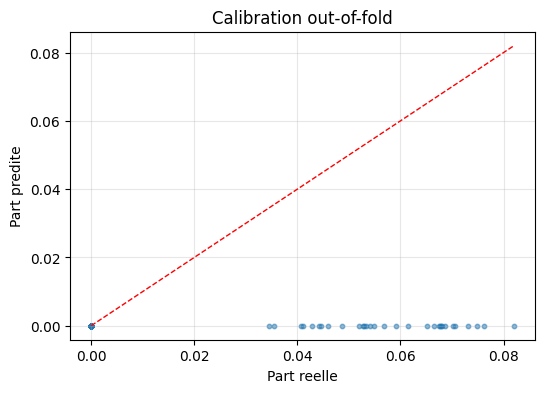

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/modelisation/Distribution des residus (y_pred - y_true).png


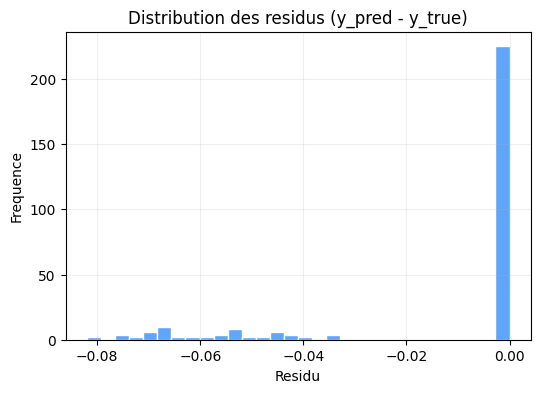

Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/modelisation/Residus vs predictions.png


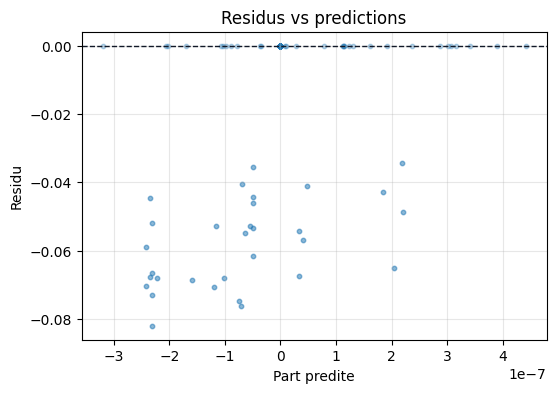

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2837861926.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bloc_mae = diag_df.groupby("bloc").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/modelisation/MAE par bloc.png


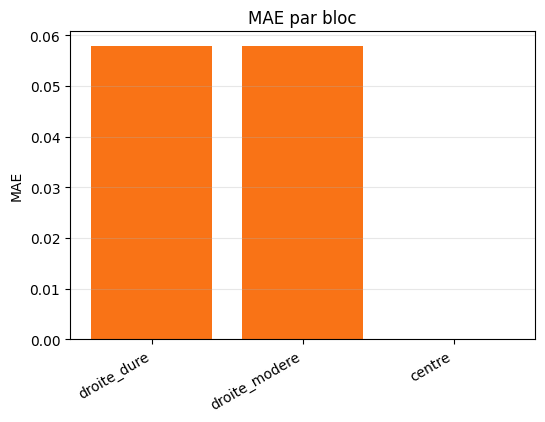

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2837861926.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


Saved: /Users/steph/Code/Python/Jupyter/Elections_Sete/output/modelisation/MAE par année.png


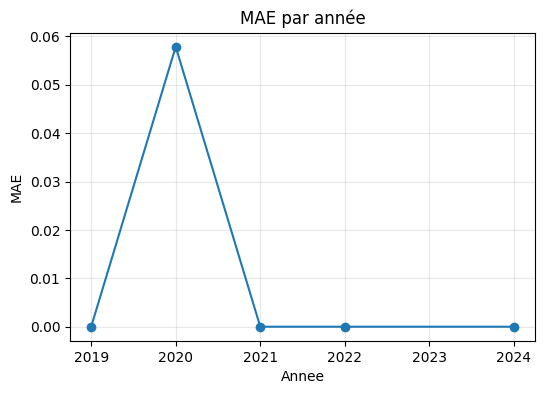

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2837861926.py:95: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


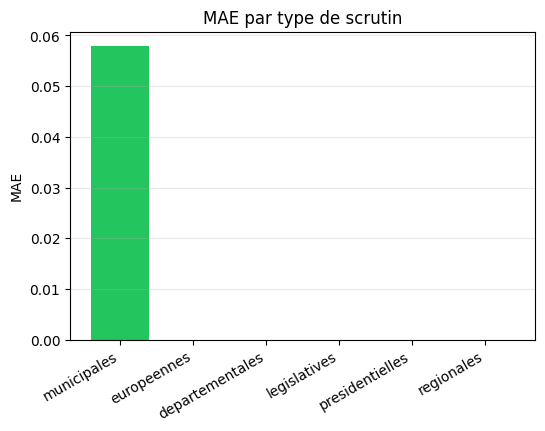

/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2837861926.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  err_by_bin = diag_df.groupby("target_bin").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/2837861926.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  err_by_bin = diag_df.groupby("target_bin").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))


In [ ]:
from sklearn.base import clone
import matplotlib.pyplot as plt

def oof_predictions(model, X, y, folds, sample_weights=None):
    preds = np.full(len(y), np.nan)
    if not folds:
        return preds
    weights = None if sample_weights is None else np.asarray(sample_weights)
    for train_idx, test_idx in folds:
        model_clone = clone(model)
        y_train = y.iloc[train_idx]
        if y_train.nunique() <= 1:
            y_train = y_train + np.random.normal(0, 1e-6, size=len(y_train))
        w_train = None if weights is None else weights[train_idx]
        fit_with_optional_weights(model_clone, X.iloc[train_idx], y_train, sample_weight=w_train)
        preds[test_idx] = model_clone.predict(X.iloc[test_idx])
    return preds

if not folds:
    print("Aucun fold disponible pour les diagnostics.")
else:
    fit_weights = sample_weights if USE_WEIGHTED_MODEL else None
    oof_pred = oof_predictions(best_model, X, y, folds, sample_weights=fit_weights)
    mask = ~np.isnan(oof_pred)
    diag_df = model_df.loc[mask, ["bloc", "code_bv"]].copy()
    diag_df["y_true"] = y[mask].values
    diag_df["y_pred"] = oof_pred[mask]
    diag_df["residual"] = diag_df["y_pred"] - diag_df["y_true"]
    diag_df["annee"] = model_df.loc[mask, "annee"].values
    diag_df["type_scrutin"] = model_df.loc[mask, "type_scrutin"].values

    # Courbe de calibration (y_true vs y_pred)
    plt.figure(figsize=(6, 4))
    plt.scatter(diag_df["y_true"], diag_df["y_pred"], alpha=0.3, s=10)
    min_val = min(diag_df["y_true"].min(), diag_df["y_pred"].min())
    max_val = max(diag_df["y_true"].max(), diag_df["y_pred"].max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)
    plt.xlabel("Part reelle")
    plt.ylabel("Part predite")
    plt.title("Calibration out-of-fold")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Residus
    plt.figure(figsize=(6, 4))
    plt.hist(diag_df["residual"], bins=30, color="#60a5fa", edgecolor="white")
    plt.title("Distribution des residus (y_pred - y_true)")
    plt.xlabel("Residu")
    plt.ylabel("Frequence")
    plt.grid(True, alpha=0.2)
    save_fig("Distribution des residus (y_pred - y_true)")
    plt.show()

    # Residus vs prediction
    plt.figure(figsize=(6, 4))
    plt.scatter(diag_df["y_pred"], diag_df["residual"], alpha=0.3, s=10)
    plt.axhline(0, color="#111827", linestyle="--", linewidth=1)
    plt.xlabel("Part predite")
    plt.ylabel("Residu")
    plt.title("Residus vs predictions")
    plt.grid(True, alpha=0.3)
    save_fig("Residus vs predictions")
    plt.show()

    # MAE par bloc
    bloc_mae = diag_df.groupby("bloc").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
    bloc_mae = bloc_mae.sort_values(ascending=False)
    plt.figure(figsize=(6, 4))
    plt.bar(bloc_mae.index, bloc_mae.values, color="#f97316")
    plt.title("MAE par bloc")
    plt.ylabel("MAE")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    save_fig("MAE par bloc")
    plt.show()

    # Erreur par annee
    err_by_year = (
        diag_df.groupby("annee")
        .apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
        .sort_index()
    )
    plt.figure(figsize=(6, 4))
    plt.plot(err_by_year.index, err_by_year.values, marker="o")
    plt.title("MAE par année")
    plt.xlabel("Annee")
    plt.ylabel("MAE")
    plt.grid(True, alpha=0.3)
    save_fig("MAE par année")
    plt.show()

    # Erreur par type de scrutin
    err_by_type = (
        diag_df.groupby("type_scrutin")
        .apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
        .sort_values(ascending=False)
    )
    plt.figure(figsize=(6, 4))
    plt.bar(err_by_type.index, err_by_type.values, color="#22c55e")
    plt.title("MAE par type de scrutin")
    plt.ylabel("MAE")
    plt.xticks(rotation=30, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

    # Erreur par quantiles de cible
    try:
        diag_df["target_bin"] = pd.qcut(diag_df["y_true"], q=5, duplicates="drop")
        err_by_bin = diag_df.groupby("target_bin").apply(lambda g: mean_absolute_error(g["y_true"], g["y_pred"]))
        err_by_bin
    except Exception as exc:
        print(f"Bins de cible indisponibles: {exc}")


In [ ]:
# Diagnostics par bins et queues d'erreur
if 'diag_df' not in globals() or diag_df.empty:
    print('diag_df indisponible pour les diagnostics bins/queues.')
else:
    diag_df = diag_df.copy()
    diag_df['abs_error'] = (diag_df['y_pred'] - diag_df['y_true']).abs()
    diag_df['bin_part'] = pd.cut(
        diag_df['y_true'],
        bins=[-0.001, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 1.0],
        labels=['<=0.05', '0.05-0.10', '0.10-0.15', '0.15-0.20', '0.20-0.25', '0.25-0.30', '>0.30'],
    )
    bin_stats = (
        diag_df.groupby('bin_part')
        .agg(
            n=('abs_error', 'size'),
            mae=('abs_error', 'mean'),
            medae=('abs_error', 'median'),
            p95=('abs_error', lambda x: x.quantile(0.95)),
            p99=('abs_error', lambda x: x.quantile(0.99)),
        )
        .reset_index()
    )
    bin_stats

    # Focus zone critique 0.12-0.15
    zone_mask = (diag_df['y_true'] >= 0.12) & (diag_df['y_true'] <= 0.15)
    zone = diag_df[zone_mask]
    if zone.empty:
        print('Aucune observation dans la zone 0.12-0.15.')
    else:
        zone_stats = {
            'n': len(zone),
            'mae': zone['abs_error'].mean(),
            'medae': zone['abs_error'].median(),
            'bias': (zone['y_pred'] - zone['y_true']).mean(),
            'p95': zone['abs_error'].quantile(0.95),
            'p99': zone['abs_error'].quantile(0.99),
        }
        zone_stats

    # Quantiles globaux de résidus
    resid = diag_df['y_pred'] - diag_df['y_true']
    resid_quantiles = resid.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_frame('residual')
    resid_quantiles


Aucune observation dans la zone 0.12-0.15.


/var/folders/by/r6dmty813rxgqdnr7hvtrl480000gn/T/ipykernel_8968/1825964428.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diag_df.groupby('bin_part')


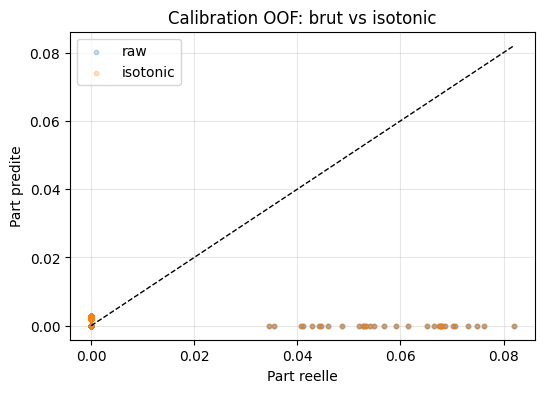

Bloc calibrators: ['centre', 'droite_dure', 'droite_modere']


In [ ]:
from sklearn.isotonic import IsotonicRegression
from sklearn.base import clone
import matplotlib.pyplot as plt

def calibrated_oof_predictions(model, X, y, folds, sample_weights=None):
    preds = np.full(len(y), np.nan)
    if not folds:
        return preds
    weights = None if sample_weights is None else np.asarray(sample_weights)
    for train_idx, test_idx in folds:
        model_clone = clone(model)
        y_train = y.iloc[train_idx]
        if y_train.nunique() <= 1:
            y_train = y_train + np.random.normal(0, 1e-6, size=len(y_train))
        w_train = None if weights is None else weights[train_idx]
        fit_with_optional_weights(model_clone, X.iloc[train_idx], y_train, sample_weight=w_train)
        pred_train = model_clone.predict(X.iloc[train_idx])
        pred_test = model_clone.predict(X.iloc[test_idx])
        iso = IsotonicRegression(out_of_bounds="clip")
        if w_train is None:
            iso.fit(pred_train, y_train)
        else:
            iso.fit(pred_train, y_train, sample_weight=w_train)
        preds[test_idx] = iso.transform(pred_test)
    return preds

bloc_calibrators = {}

if not folds:
    print("Aucun fold disponible pour la calibration.")
else:
    fit_weights = sample_weights if USE_WEIGHTED_MODEL else None
    if "oof_pred" not in globals():
        oof_pred = oof_predictions(best_model, X, y, folds, sample_weights=fit_weights)
    oof_pred_cal = calibrated_oof_predictions(best_model, X, y, folds, sample_weights=fit_weights)
    mask = ~np.isnan(oof_pred) & ~np.isnan(oof_pred_cal)
    if mask.sum() == 0:
        print("Pas de predictions OOF pour la calibration.")
    else:
        metrics_raw = regression_metrics(y[mask], oof_pred[mask])
        metrics_cal = regression_metrics(y[mask], oof_pred_cal[mask])
        winner_raw = winner_accuracy(
            y[mask].values,
            oof_pred[mask],
            blocs=model_df.loc[mask, "bloc"],
            bv_codes=model_df.loc[mask, "code_bv"],
        )
        winner_cal = winner_accuracy(
            y[mask].values,
            oof_pred_cal[mask],
            blocs=model_df.loc[mask, "bloc"],
            bv_codes=model_df.loc[mask, "code_bv"],
        )
        calib_metrics = pd.DataFrame(
            [
                {"version": "raw", **metrics_raw, "winner_acc": winner_raw},
                {"version": "isotonic", **metrics_cal, "winner_acc": winner_cal},
            ]
        )
        calib_metrics

        plt.figure(figsize=(6, 4))
        plt.scatter(y[mask], oof_pred[mask], alpha=0.25, s=10, label="raw")
        plt.scatter(y[mask], oof_pred_cal[mask], alpha=0.25, s=10, label="isotonic")
        min_val = float(np.nanmin([y[mask].min(), oof_pred[mask].min(), oof_pred_cal[mask].min()]))
        max_val = float(np.nanmax([y[mask].max(), oof_pred[mask].max(), oof_pred_cal[mask].max()]))
        plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
        plt.xlabel("Part reelle")
        plt.ylabel("Part predite")
        plt.title("Calibration OOF: brut vs isotonic")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # Calibration par bloc (isotonic)
    if "diag_df" in globals() and not diag_df.empty:
        min_samples = 30
        for bloc, g in diag_df.groupby("bloc"):
            if len(g) < min_samples:
                continue
            iso_bloc = IsotonicRegression(out_of_bounds="clip")
            iso_bloc.fit(g["y_pred"], g["y_true"])
            bloc_calibrators[bloc] = iso_bloc
        print(f"Bloc calibrators: {sorted(bloc_calibrators.keys())}")
    else:
        print("diag_df indisponible pour la calibration par bloc.")

    pred_full = best_model.predict(X)
    if np.unique(pred_full).size < 2:
        print("Calibration isotonic ignoree (predictions trop constantes).")
        iso_calibrator = None
    else:
        iso_calibrator = IsotonicRegression(out_of_bounds="clip")
        if fit_weights is None:
            iso_calibrator.fit(pred_full, y)
        else:
            iso_calibrator.fit(pred_full, y, sample_weight=fit_weights)

def apply_bloc_calibration(df: pd.DataFrame, pred_col: str = "p_raw", out_col: str = "p_calib") -> pd.DataFrame:
    out = df.copy()
    out[out_col] = out[pred_col]
    if not bloc_calibrators:
        return out
    for bloc, iso_bloc in bloc_calibrators.items():
        mask = out["bloc"] == bloc
        if mask.any():
            out.loc[mask, out_col] = iso_bloc.transform(out.loc[mask, pred_col])
    return out


## Courbes d'apprentissage
Visualisation du biais/variance du meilleur modèle sur un sous-échantillon chronologique (limité pour rester rapide).


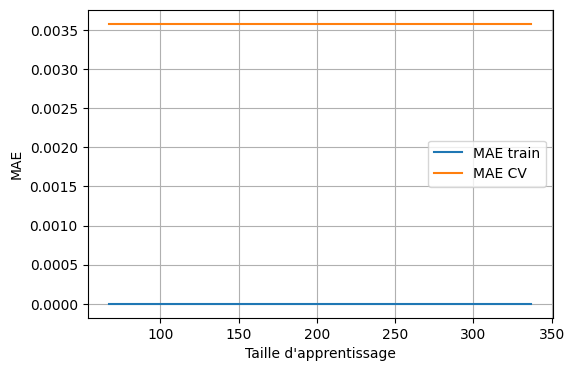

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.base import clone
import matplotlib.pyplot as plt

subset = model_df.sort_values("annee").head(min(len(model_df), 5000))
if len(subset) < 5:
    print("Pas assez d'observations pour une courbe d'apprentissage fiable.")
else:
    X_lc, y_lc = subset[feature_cols], subset["part_bloc"]
    n_splits = min(3, len(subset) - 1)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_sizes, train_scores, val_scores = learning_curve(
        clone(best_model),
        X_lc,
        y_lc,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        train_sizes=np.linspace(0.2, 1.0, 5),
        n_jobs=1,
        shuffle=False,
    )
    lc_results = pd.DataFrame(
        {
            "train_size": train_sizes,
            "mae_train": -train_scores.mean(axis=1),
            "mae_cv": -val_scores.mean(axis=1),
        }
    )
    plt.figure(figsize=(6, 4))
    plt.plot(lc_results["train_size"], lc_results["mae_train"], label="MAE train")
    plt.plot(lc_results["train_size"], lc_results["mae_cv"], label="MAE CV")
    plt.xlabel("Taille d'apprentissage")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.show()
    lc_results


## SHAP (importance des features)
Analyse locale/globale des variables du meilleur modèle sur un échantillon limité.


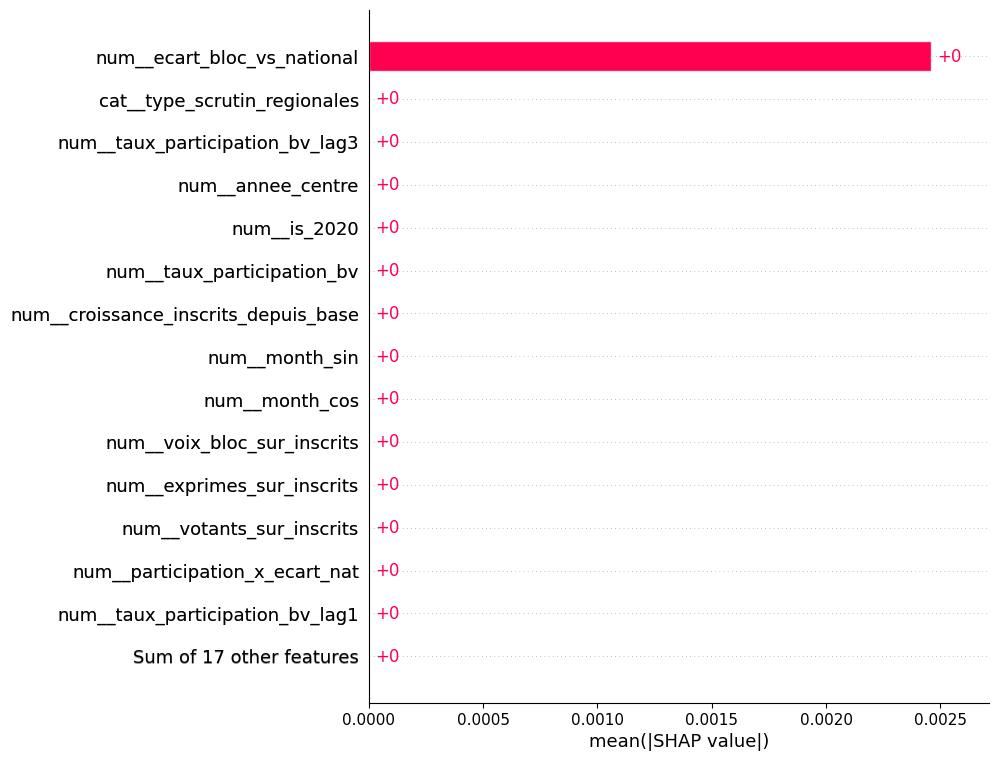

In [ ]:
try:
    import shap
    shap.initjs()
    sample = model_df.sample(min(len(model_df), 1000), random_state=42)
    X_sample = sample[feature_cols]
    prep = best_model.named_steps.get("prep") if hasattr(best_model, "named_steps") else None
    estimator = best_model.named_steps.get("model") if hasattr(best_model, "named_steps") else best_model
    X_trans = prep.transform(X_sample) if prep is not None else X_sample
    if hasattr(X_trans, "toarray"):
        X_trans = X_trans.toarray()
    feature_names = None
    if prep is not None and hasattr(prep, "get_feature_names_out"):
        feature_names = prep.get_feature_names_out()
    explainer = shap.Explainer(estimator, X_trans, feature_names=feature_names)
    shap_values = explainer(X_trans[:200])
    shap.plots.bar(shap_values, max_display=15)
except Exception as exc:
    print(f"Impossible de calculer les valeurs SHAP: {exc}")


## Construction du jeu cible pour 2026
- On repart de la dernière observation de chaque bureau x bloc
- On positionne l'année et la date sur 2026, type_scrutin="municipales", tour=1
- Les variables de lag restent celles de la dernière élection connue (proxy réaliste à court terme)
- Les features sont recalculées puis passées au modèle

In [ ]:
def build_target_rows(
    df: pd.DataFrame,
    target_year: int = TARGET_YEAR,
    target_election: str = TARGET_ELECTION,
    target_tour: int = TARGET_TOUR,
):
    base = prepare_base_table(df)
    if base.empty:
        return base
    median_annee = base["annee"].median() if "annee" in base.columns else target_year
    latest = (
        base.sort_values("date_scrutin")
        .groupby(["code_bv", "bloc"], as_index=False)
        .tail(1)
        .copy()
    )
    latest["annee"] = target_year
    latest["date_scrutin"] = pd.Timestamp(f"{target_year}-03-15")
    latest["type_scrutin"] = target_election
    latest["tour"] = target_tour
    latest["annee_centre"] = target_year - median_annee
    latest["part_bloc"] = np.nan
    latest["is_target"] = True
    base["is_target"] = False

    stacked = pd.concat([base, latest], ignore_index=True, sort=False)
    stacked = add_calendar_features(stacked)
    stacked = add_lag_rolling_features(stacked)
    stacked = add_bureau_bloc_features(stacked)
    stacked = add_commune_bloc_features(stacked)
    stacked = add_interaction_features(stacked)

    target_rows = stacked[stacked["is_target"]].drop(columns=["is_target"])
    return target_rows

X_target_full = build_target_rows(base_df)
X_target = X_target_full[feature_cols]

pred_part = best_model.predict(X_target)

pred_df = X_target_full[["code_bv", "bloc"]].copy()
if "code_commune" in X_target_full.columns:
    pred_df["code_commune"] = X_target_full["code_commune"].astype(str)

pred_df["p_raw"] = pred_part

if "apply_bloc_calibration" in globals():
    pred_df = apply_bloc_calibration(pred_df, pred_col="p_raw", out_col="p_calib")
else:
    pred_df["p_calib"] = pred_df["p_raw"]

pred_df = normalize_predictions_by_bureau(pred_df, pred_col="p_calib", out_col="p_norm")

winners = (
    pred_df.loc[pred_df.groupby("code_bv")["p_norm"].idxmax(), ["code_bv", "bloc"]]
    .rename(columns={"bloc": "bloc_gagnant"})
)

pred_df = pred_df.merge(winners, on="code_bv", how="left")

pred_df.head()


,code_bv,bloc,code_commune,p_raw,p_calib,p_norm,bloc_gagnant
0,343010001,centre,34301,0.000000,0.00000,0.0,droite_dure
1,343010001,droite_dure,34301,0.045966,0.05786,0.5,droite_dure
2,343010001,droite_modere,34301,0.045966,0.05786,0.5,droite_dure
3,343010002,centre,34301,0.000000,0.00000,0.0,droite_dure
4,343010002,droite_dure,34301,0.045966,0.05786,0.5,droite_dure


## Calcul des deltas vs législatives précédentes et municipales 2020
Permet d'afficher dans Gradio l'écart à N-1 (législatives) et aux municipales 2020.

In [ ]:
history = build_model_table(base_df, drop_na_target=True)

last_leg = (
    history[history["type_scrutin"] == "legislatives"]
    .sort_values("date_scrutin")
    .groupby(["code_bv", "bloc"], as_index=False)
    .tail(1)
    .rename(columns={"part_bloc": "part_leg"})
)
last_mun2020 = (
    history[(history["type_scrutin"] == "municipales") & (history["annee"] == 2020)]
    .sort_values("date_scrutin")
    .groupby(["code_bv", "bloc"], as_index=False)
    .tail(1)
    .rename(columns={"part_bloc": "part_mun2020"})
)

pred_df = pred_df.merge(last_leg[["code_bv", "bloc", "part_leg"]], on=["code_bv", "bloc"], how="left")
pred_df = pred_df.merge(last_mun2020[["code_bv", "bloc", "part_mun2020"]], on=["code_bv", "bloc"], how="left")

pred_df["delta_leg"] = pred_df["p_norm"] - pred_df["part_leg"]
pred_df["delta_mun2020"] = pred_df["p_norm"] - pred_df["part_mun2020"]

if "p_calib" in pred_df.columns:
    pred_df["delta_leg_calib"] = pred_df["p_calib"] - pred_df["part_leg"]
    pred_df["delta_mun2020_calib"] = pred_df["p_calib"] - pred_df["part_mun2020"]

pred_df.head(20)


,code_bv,bloc,code_commune,p_raw,p_calib,p_norm,bloc_gagnant,part_leg,part_mun2020,delta_leg,delta_mun2020,delta_leg_calib,delta_mun2020_calib
0,343010001,centre,34301,0.000000,0.00000,0.0,droite_dure,0.0,NaN,0.0,NaN,0.0,NaN
1,343010001,droite_dure,34301,0.045966,0.05786,0.5,droite_dure,NaN,0.054147,NaN,0.445853,NaN,0.003712
2,343010001,droite_modere,34301,0.045966,0.05786,0.5,droite_dure,NaN,0.054147,NaN,0.445853,NaN,0.003712
3,343010002,centre,34301,0.000000,0.00000,0.0,droite_dure,0.0,NaN,0.0,NaN,0.0,NaN
4,343010002,droite_dure,34301,0.045966,0.05786,0.5,droite_dure,NaN,0.034409,NaN,0.465591,NaN,0.023451
5,343010002,droite_modere,34301,0.045966,0.05786,0.5,droite_dure,NaN,0.034409,NaN,0.465591,NaN,0.023451
6,343010003,centre,34301,0.000000,0.00000,0.0,droite_dure,0.0,NaN,0.0,NaN,0.0,NaN
7,343010003,droite_dure,34301,0.045966,0.05786,0.5,droite_dure,NaN,0.054795,NaN,0.445205,NaN,0.003065
8,343010003,droite_modere,34301,0.045966,0.05786,0.5,droite_dure,NaN,0.054795,NaN,0.445205,NaN,0.003065
9,343010004,centre,34301,0.000000,0.00000,0.0,droite_dure,0.0,NaN,0.0,NaN,0.0,NaN


## Sauvegarde des prédictions
- Format long : `data/processed/predictions_municipales_2026.csv`
- Pivot par bloc : `data/processed/predictions_municipales_2026_blocs.csv`
- Filtre Sète (code commune 34301/301) : `data/processed/predictions_municipales_sete_2026.csv`

In [ ]:
pred_out = pred_df.copy()
pred_out.to_csv(PROCESSED_DIR / "predictions_municipales_2026.csv", sep=";", index=False)

pivot = pred_out.pivot(index="code_bv", columns="bloc", values="p_norm")
pivot.to_csv(PROCESSED_DIR / "predictions_municipales_2026_blocs.csv", sep=";")

if "code_commune" in pred_out.columns:
    pred_sete = pred_out[pred_out["code_commune"].astype(str) == SETE_CODE_COMMUNE]
else:
    def is_sete(code_bv: str) -> bool:
        return isinstance(code_bv, str) and code_bv.startswith(SETE_CODE_COMMUNE)
    pred_sete = pred_out[pred_out["code_bv"].astype(str).apply(is_sete)]

pred_sete.to_csv(PROCESSED_DIR / "predictions_municipales_sete_2026.csv", sep=";", index=False)

pred_out.head(), pivot.head(), pred_sete.head()


(     code_bv           bloc code_commune     p_raw  p_calib  p_norm  \
 0  343010001         centre        34301  0.000000  0.00000     0.0   
 1  343010001    droite_dure        34301  0.045966  0.05786     0.5   
 2  343010001  droite_modere        34301  0.045966  0.05786     0.5   
 3  343010002         centre        34301  0.000000  0.00000     0.0   
 4  343010002    droite_dure        34301  0.045966  0.05786     0.5   
 
   bloc_gagnant  part_leg  part_mun2020  delta_leg  delta_mun2020  \
 0  droite_dure       0.0           NaN        0.0            NaN   
 1  droite_dure       NaN      0.054147        NaN       0.445853   
 2  droite_dure       NaN      0.054147        NaN       0.445853   
 3  droite_dure       0.0           NaN        0.0            NaN   
 4  droite_dure       NaN      0.034409        NaN       0.465591   
 
    delta_leg_calib  delta_mun2020_calib  
 0              0.0                  NaN  
 1              NaN             0.003712  
 2              NaN  

## Pistes d'amélioration
- Enrichir avec variables socio-démo INSEE (CSP, âge, revenus) au niveau IRIS/bureau
- Ajouter effets spatiaux (voisinage) et MRP/hiérarchiques pour lisser les petits bureaux
- Calibration / incertitude : bootstrap ou simulation Monte Carlo
- Optimiser les hyperparamètres (Optuna, RandomizedSearchCV) et ajouter SHAP pour l'explicabilité